# Pruning with Сatalyst

In [1]:
import os
import numpy as np
import json
from pathlib import Path

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.utils.prune as prune

from catalyst import dl
from catalyst import utils
from catalyst.contrib.datasets import MNIST
from catalyst.contrib.nn import Flatten
from catalyst.data.cv.transforms.torch import ToTensor

sns.set(style="darkgrid", font_scale=1.4)

## Loading data

In our experiments we will use MNIST dataset.

In [3]:
train_dataset = MNIST(
    root="./", download=True, train=True, transform=ToTensor()
)
val_dataset = MNIST(
    root="./", download=True, train=False, transform=ToTensor()
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
loaders = {"train": train_dataloader, "valid": val_dataloader}

Fix random seed

In [4]:
utils.set_global_seed(42)

## Useful function

Before we start we need to create `mask_{layer}` field in our model state dict. The most simpliest way to do so is to perform pruning with identity mask.

In [5]:
def create_identity_mask(model, tensor_name="weight"):
    for _name, module in model.named_modules():
        try:
            prune.identity(module, "weight")
        except Exception as e:
            print(e)
            pass

In [6]:
net = nn.Sequential(
    Flatten(),
    nn.Linear(28*28, 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)
create_identity_mask(net)
initial_state_dict = net.state_dict()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

'Sequential' object has no attribute 'weight'
'Flatten' object has no attribute 'weight'
'ReLU' object has no attribute 'weight'
'ReLU' object has no attribute 'weight'


## Naive pruning

In [7]:
runner = dl.SupervisedRunner(device="cuda:1")

runner.train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=[
        dl.AccuracyCallback(num_classes=10),
    ],
    verbose=True,
    logdir="./logdir",
    num_epochs=10,
    load_best_on_end=True,
    main_metric="accuracy01",
    minimize_metric=False
)

1/10 * Epoch (train): 100% 1875/1875 [00:14<00:00, 132.15it/s, accuracy01=0.969, accuracy03=1.000, accuracy05=1.000, loss=0.165]
1/10 * Epoch (valid): 100% 157/157 [00:01<00:00, 149.78it/s, accuracy01=1.000, accuracy03=1.000, accuracy05=1.000, loss=0.012]
[2020-09-25 19:59:43,413] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.9268 | accuracy03=0.9846 | accuracy05=0.9950 | loss=0.2461
1/10 * Epoch 1 (valid): accuracy01=0.9651 | accuracy03=0.9961 | accuracy05=0.9991 | loss=0.1155
2/10 * Epoch (train): 100% 1875/1875 [00:14<00:00, 132.53it/s, accuracy01=0.969, accuracy03=1.000, accuracy05=1.000, loss=0.110]
2/10 * Epoch (valid): 100% 157/157 [00:01<00:00, 151.14it/s, accuracy01=1.000, accuracy03=1.000, accuracy05=1.000, loss=0.007]    
[2020-09-25 19:59:58,659] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.9702 | accuracy03=0.9971 | accuracy05=0.9995 | loss=0.0968
2/10 * Epoch 2 (valid): accuracy01=0.9

In [8]:
pruning = dl.PruningCallback(
    prune.l1_unstructured, 
    keys_to_prune=["weight"], 
    amount=0.1, 
    prune_on_stage_end=True,
    remove_reparametrization_on_stage_end=False,
)

In [9]:
accuracy_scores = []
pruned_weights = []
c_p = 1
for pruning_idx in range(35):
    correct = 0
    for batch in loaders["valid"]:
        outp = runner.predict_batch(batch)
        c_correct = torch.sum(outp["logits"].argmax(-1).detach().cpu() == batch[1]).item()
        correct += c_correct
    pruned_weights.append(c_p)
    c_p *= 0.9
    accuracy_scores.append(correct / len(val_dataset))
    pruning.on_stage_end(runner)

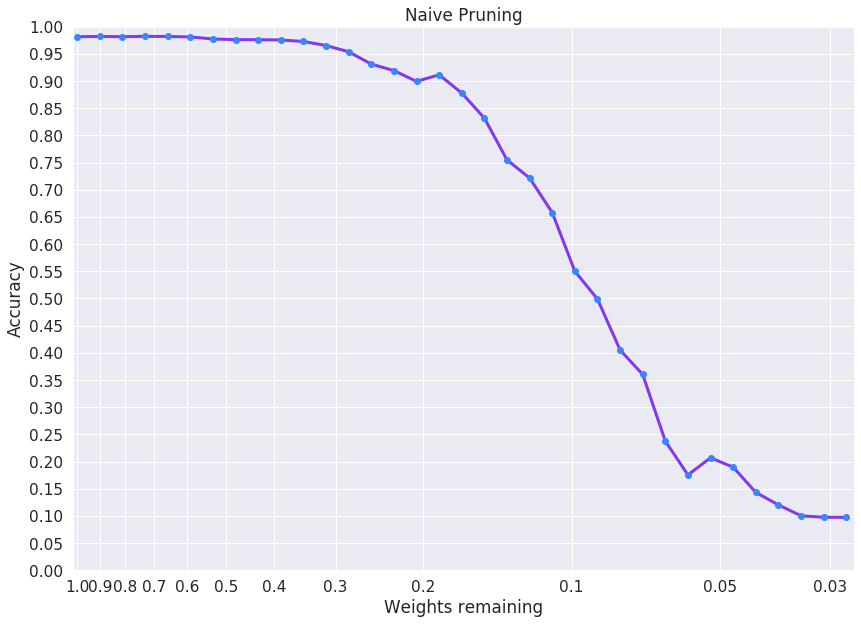

In [10]:
plt.figure(figsize=(14, 10))
plt.title("Naive Pruning")
plt.plot(pruned_weights, accuracy_scores,  color="#8338ec", linewidth=3)
plt.plot(pruned_weights, accuracy_scores, "o", color="#3a86ff")
plt.xlim(1+2e-2, min(pruned_weights)-1e-3)
plt.xscale("log")
plt.xticks([i/10 for i in range(11)][1:]+[0.05]+[0.03], [i/10 for i in range(11)][1:]+[0.05]+[0.03])
plt.xlabel("Weights remaining")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.yticks([i/20 for i in range(21)])
plt.show()

In [11]:
net.load_state_dict(initial_state_dict)

<All keys matched successfully>

In [12]:
def merge_state_dict(start_dict, new_dict):
    out_dict = {}
    for k, v in start_dict.items():
        if "mask" in k:
            out_dict[k] = new_dict[k]
        else:
            out_dict[k] = v
    return out_dict

## Iterative pruning

In [13]:
callbacks = [
    dl.AccuracyCallback(num_classes=10),
    dl.PruningCallback(
        prune.l1_unstructured, 
        keys_to_prune=["weight"], 
        amount=0.1,
        remove_reparametrization_on_stage_end=False,
    )
]

In [14]:
for stage in range(35):
    runner = dl.SupervisedRunner(device="cuda:1")
    runner.train(
        model=net,
        optimizer=optimizer,
        callbacks=callbacks,
        loaders=loaders,
        num_epochs=10,
        criterion=criterion,
        check=False,
        logdir=f"logs/{stage}_reinit",
        main_metric="accuracy01",
        minimize_metric=False,
    )

[2020-09-25 20:02:30,701] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.9346 | accuracy03=0.9869 | accuracy05=0.9950 | loss=0.2141
1/10 * Epoch 1 (valid): accuracy01=0.9679 | accuracy03=0.9971 | accuracy05=0.9993 | loss=0.1022
[2020-09-25 20:02:42,539] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.9741 | accuracy03=0.9973 | accuracy05=0.9996 | loss=0.0846
2/10 * Epoch 2 (valid): accuracy01=0.9788 | accuracy03=0.9979 | accuracy05=0.9996 | loss=0.0716
[2020-09-25 20:02:54,230] 
3/10 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.9823 | accuracy03=0.9990 | accuracy05=0.9998 | loss=0.0556
3/10 * Epoch 3 (valid): accuracy01=0.9773 | accuracy03=0.9977 | accuracy05=0.9999 | loss=0.0731
[2020-09-25 20:03:06,010] 
4/10 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/10 * Epoch 4 (train): accuracy01=0.9869 | accuracy03=0.9993 | accuracy05=0.9999 | loss=0.0403
4/10 * Epoch

In [15]:
accuracy_scores_reinit = []
for i in range(35):
    with open("logs/"+str(i)+"_reinit/checkpoints/_metrics.json", "r") as inp:
        c_dict = json.load(inp)
        accuracy_scores_reinit.append(c_dict["best"]["accuracy01"])

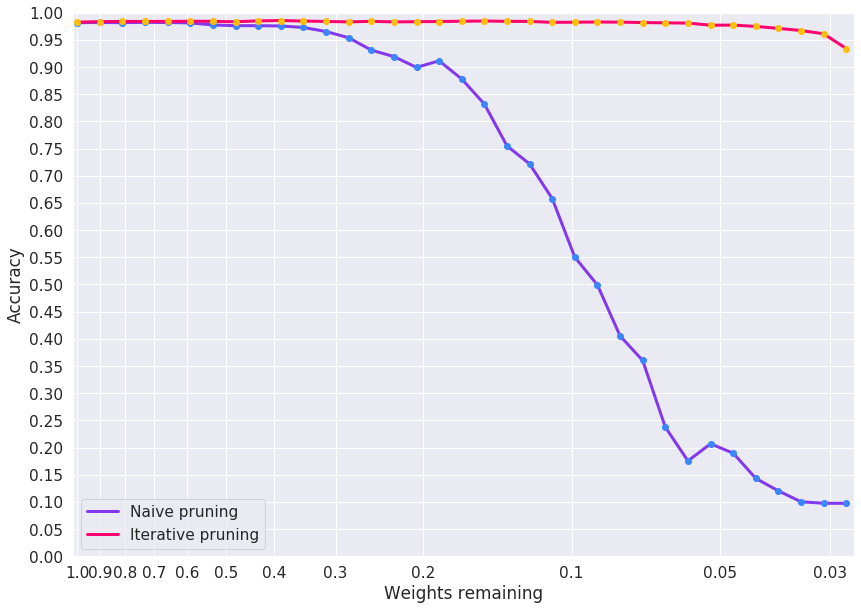

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(pruned_weights, accuracy_scores,  color="#8338ec", linewidth=3, label="Naive pruning")
plt.plot(pruned_weights, accuracy_scores, "o", color="#3a86ff")
plt.plot(pruned_weights, accuracy_scores_reinit, color="#ff006e", linewidth=3, label="Iterative pruning")
plt.plot(pruned_weights, accuracy_scores_reinit, "o", color="#ffbe0b")
plt.xlim(1+2e-2, min(pruned_weights)-1e-3)
plt.xscale("log")
plt.xticks([i/10 for i in range(11)][1:]+[0.05]+[0.03], [i/10 for i in range(11)][1:]+[0.05]+[0.03])
plt.xlabel("Weights remaining")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.yticks([i/20 for i in range(21)])
plt.legend()
plt.show()

In [18]:
net.load_state_dict(initial_state_dict)

<All keys matched successfully>

## Lottery ticket

In [19]:
for stage in range(35):
    optimizer = torch.optim.Adam(net.parameters())
    runner = dl.SupervisedRunner(device="cuda:1")
    runner.train(
        model=net,
        optimizer=optimizer,
        callbacks=callbacks,
        loaders=loaders,
        num_epochs=10,
        criterion=criterion,
        check=False,
        logdir=f"logs/{stage}",
        main_metric="accuracy01",
        minimize_metric=False,
    )
    to_load = merge_state_dict(initial_state_dict, net.state_dict())
    net.load_state_dict(to_load)

[2020-09-25 21:19:21,975] 
1/10 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.9268 | accuracy03=0.9846 | accuracy05=0.9950 | loss=0.2461
1/10 * Epoch 1 (valid): accuracy01=0.9651 | accuracy03=0.9961 | accuracy05=0.9991 | loss=0.1155
[2020-09-25 21:19:34,293] 
2/10 * Epoch 2 (_base): lr=0.0010 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.9702 | accuracy03=0.9971 | accuracy05=0.9995 | loss=0.0968
2/10 * Epoch 2 (valid): accuracy01=0.9762 | accuracy03=0.9977 | accuracy05=0.9997 | loss=0.0778
[2020-09-25 21:19:46,723] 
3/10 * Epoch 3 (_base): lr=0.0010 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.9805 | accuracy03=0.9985 | accuracy05=0.9998 | loss=0.0634
3/10 * Epoch 3 (valid): accuracy01=0.9768 | accuracy03=0.9978 | accuracy05=0.9998 | loss=0.0760
[2020-09-25 21:19:59,022] 
4/10 * Epoch 4 (_base): lr=0.0010 | momentum=0.9000
4/10 * Epoch 4 (train): accuracy01=0.9847 | accuracy03=0.9992 | accuracy05=0.9999 | loss=0.0480
4/10 * Epoch

In [20]:
accuracy_scores_lt = []
for i in range(35):
    with open("logs/"+str(i)+"/checkpoints/_metrics.json", "r") as inp:
        c_dict = json.load(inp)
        accuracy_scores_lt.append(c_dict["best"]["accuracy01"])

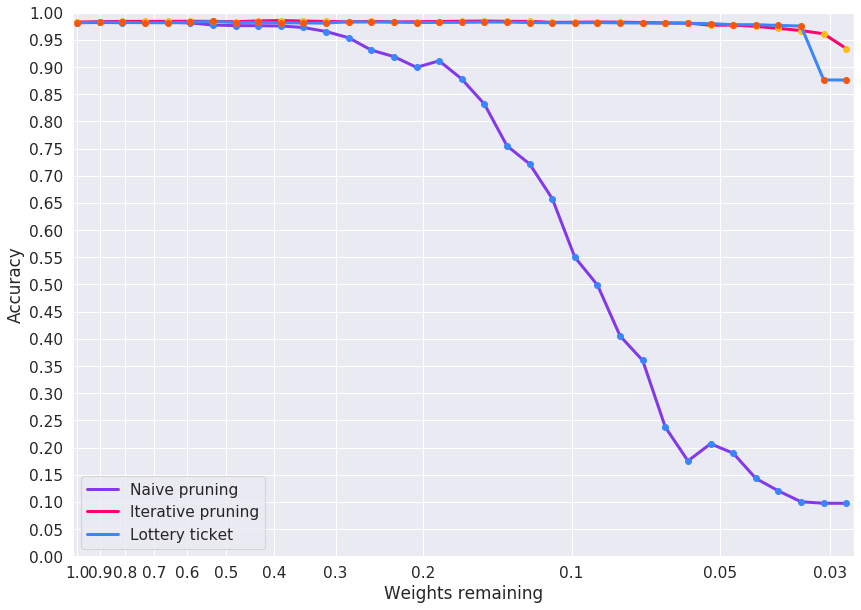

In [28]:
plt.figure(figsize=(14, 10))
plt.plot(pruned_weights, accuracy_scores,  color="#8338ec", linewidth=3, label="Naive pruning")
plt.plot(pruned_weights, accuracy_scores, "o", color="#3a86ff")
plt.plot(pruned_weights, accuracy_scores_reinit, color="#ff006e", linewidth=3, label="Iterative pruning")
plt.plot(pruned_weights, accuracy_scores_reinit, "o", color="#ffbe0b")
plt.plot(pruned_weights, accuracy_scores_lt,  color="#3a86ff", linewidth=3, label="Lottery ticket")
plt.plot(pruned_weights, accuracy_scores_lt, "o", color="#fb5607")
plt.xlim(1+2e-2, min(pruned_weights)-1e-3)
plt.xscale("log")
plt.xticks([i/10 for i in range(11)][1:]+[0.05]+[0.03], [i/10 for i in range(11)][1:]+[0.05]+[0.03])
plt.xlabel("Weights remaining")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.yticks([i/20 for i in range(21)])
plt.legend()
plt.show()

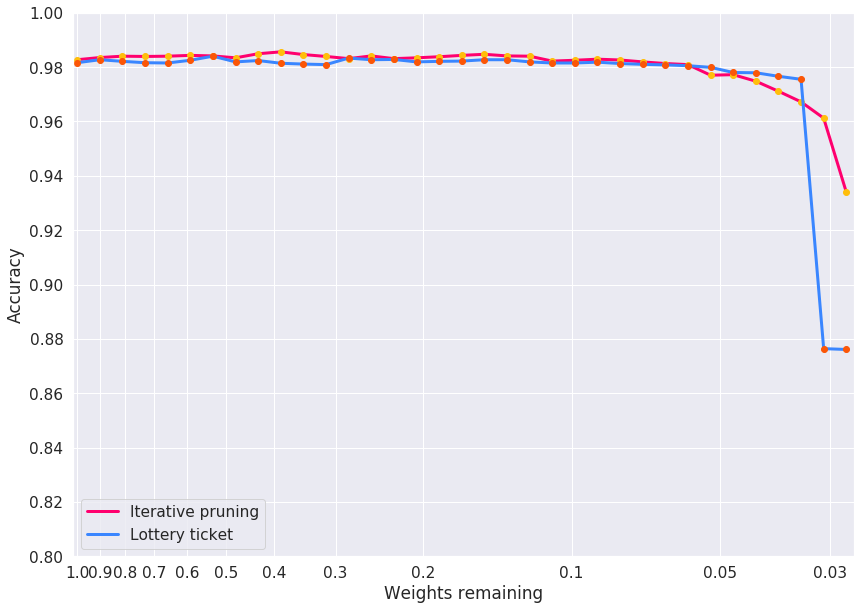

In [27]:
plt.figure(figsize=(14, 10))
plt.plot(pruned_weights, accuracy_scores_reinit, color="#ff006e", linewidth=3, label="Iterative pruning")
plt.plot(pruned_weights, accuracy_scores_reinit, "o", color="#ffbe0b")
plt.plot(pruned_weights, accuracy_scores_lt,  color="#3a86ff", linewidth=3, label="Lottery ticket")
plt.plot(pruned_weights, accuracy_scores_lt, "o", color="#fb5607")
plt.xlim(1+2e-2, min(pruned_weights)-1e-3)
plt.xscale("log")
plt.xticks([i/10 for i in range(11)][1:]+[0.05]+[0.03], [i/10 for i in range(11)][1:]+[0.05]+[0.03])
plt.xlabel("Weights remaining")
plt.ylabel("Accuracy")
plt.yticks([i/50 for i in range(51)])
plt.ylim(0.8, 1)
plt.legend()
plt.show()